# Multi-class FSA

1. Implement the FSA variable selection method with linear models for multi-class
classification with the Vapnik los
$L(\bf{u}, y) = \Sigma_{k\not=y} l(u_y-u_k)$

where $l(u)$ is the logistic loss described in class. Use the parameters $\lambda = 0.0001, \mu =
100, N^{iter} = 500$.
Take special care to normalize each column of the $X$ matrix to have zero mean
and variance $1$ and to use for normalizing the test set the same mean and standard
deviation that you used for normalizing the training set.
Assuming that the coefficient vector is a $p \times c$ matrix $W$, where $p$ is the number of
features and c is the number of classes, use the norm $||\bf{w}_j||, j = 1, ..., p$ of each row as
the criterion to select the variables in FSA.

Import dependencies

In [20]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score

#### Normalization function

In [21]:
def normalize(train, *args):
    mean = np.average(train, axis=0)
    standard_deviation = np.std(train, axis=0)
    columns = train, *args
    return tuple(np.divide(column-mean, standard_deviation, where=standard_deviation!=0)
                 for column in columns)

#### Load data

In [22]:
def get_data():
    path = "data/satimage/"

    train_x = np.loadtxt(path + "X.dat")
    train_y_temp = np.loadtxt(path + "Y.dat", dtype=np.int)
    test_x = np.loadtxt(path + "Xtest.dat")
    test_y_temp = np.loadtxt(path + "Ytest.dat", dtype=np.int)

    train_x, test_x = normalize(train_x, test_x)

    train_y = np.zeros((train_y_temp.size,np.max(train_y_temp)))
    train_y[np.arange(train_y_temp.size),train_y_temp-1] = 1

    test_y = np.zeros((test_y_temp.size,train_y.shape[1]))
    test_y[np.arange(test_y_temp.size),test_y_temp-1] = 1

    return train_x, train_y, test_x, test_y



#### Calculate the next iteration's weights

In [23]:
def update_weights(w, x, y, loss):
    learning_rate = .00001
    return w + learning_rate * loss(w, x, y)

def L(w, x, y):
    """
    Gradient of logistic loss
    """
    s = 0.0001
    w = torch.from_numpy(w)
    x = torch.from_numpy(x)
    y = torch.from_numpy(y)

    w.requires_grad = True
    y_predicted = torch.matmul(x,w)
    difference = y - y_predicted
    difference[y==1] = difference[y==1] - difference[y==1]
    loss = torch.log(1 + torch.exp(-difference))
    loss[torch.isnan(loss)] = -difference[torch.isnan(loss)]
    loss = torch.sum(loss)
    loss.backward()
    gradient = w.grad
    return gradient.numpy()

def L2(w, x, y):
    """
    Gradient of cross entropy loss
    """
    s = 0.0001
    w = torch.from_numpy(w)
    x = torch.from_numpy(x)
    y = torch.from_numpy(y)

    w.requires_grad = True
    y_predicted = torch.matmul(x,w)
    loss= torch.nn.CrossEntropyLoss()(y_predicted, torch.argmax(y, axis=1))
    loss.backward()
    gradient = w.grad + 2 * s * 2
    return gradient.numpy()


def predict(X,w):
    """
    Predictor function for logistic regression
    """
    z = X @ w
    z /= np.sum(z,axis=1).reshape(-1,1)
    result = np.zeros_like(z)
    result[np.arange(z.shape[0]), np.argmax(z, axis=1)] = 1
    return result

#### Calculate the number of parameters to keep

In [24]:
def calc_schedule(num_params, k, num_iterations):
    mu = 100
    return [round(k+(num_params-k)*max(0,(num_iterations-2*i)/(2*i*mu+num_iterations)))
            for i in range(1,num_iterations+1)]

#### Eliminate Parameters

In [25]:
def eliminate_parameters(parameters_to_keep, w, x_train, x_test):
    """
    Eliminates the parameters which have the smallest weights so that parameters_to_keep parameter remain
    """
    # list of indexes that would sort the array
    sorted_indexes = np.argsort(np.linalg.norm(w, axis=1))
    # index thresholds used to eliminate insignificant parameters
    threshold = w.shape[0] - parameters_to_keep
    # delete indexes smaller than threshold
    w = np.delete(w, sorted_indexes[sorted_indexes < threshold], axis=0)
    x_train = np.delete(x_train, sorted_indexes[sorted_indexes < threshold], axis=1)
    x_test = np.delete(x_test, sorted_indexes[sorted_indexes < threshold], axis=1)
    return w, x_train, x_test


#### Train logistic regression model using FSA

In [26]:
def train_fsa(x_train, y_train, x_test, y_test, k, loss):
    iterations = 500
    x_train, x_test = normalize(x_train, x_test)
    # append column of ones for the intercept
    x_train = np.hstack((np.ones((x_train.shape[0], 1)), x_train))
    x_test = np.hstack((np.ones((x_test.shape[0], 1)), x_test))

    w = np.zeros((x_train.shape[1], y_train.shape[1])) # initializing weights to 0
    schedule = calc_schedule(w.shape[0], k, iterations)
    train_scores = []
    test_scores = []
    train_scores.append(1 - accuracy_score(y_train, predict(x_train, w)))
    test_scores.append(1 - accuracy_score(y_test, predict(x_test, w)))
    for parameters_to_keep in schedule:
        if parameters_to_keep == 0:
            break
        w = update_weights(w, x_train, y_train, loss)
        w, x_train, x_test = eliminate_parameters(parameters_to_keep, w, x_train, x_test)
        train_scores.append(1 - accuracy_score(y_train, predict(x_train, w)))
        test_scores.append(1 - accuracy_score(y_test, predict(x_test, w)))
    number_of_features = w.shape[0]

    return test_scores, train_scores, number_of_features



In [27]:
def plot(features, test_errors, train_errors, train_errors_to_plot, test_errors_to_plot):
    iteration = list(range(len(train_errors_to_plot)))
    plt.plot(iteration, train_errors_to_plot);
    plt.plot(iteration, test_errors_to_plot);
    plt.legend(["Train", "Test"])
    plt.xlabel("Iterations")
    plt.ylabel("Misclassification error")
    plt.title("Error vs iterations with 27 features")
    plt.show()

    plt.plot(features, train_errors)
    plt.plot(features, test_errors)
    plt.legend(["Train", "Test"])
    plt.xlabel("Number of features")
    plt.ylabel("Final misclassification error")
    plt.title("Features vs misclassification error")

    test_errors = [f"{test_error:.3f}" for test_error in test_errors]
    train_errors = [f"{train_error:.3f}" for train_error in train_errors]
    plt.table(cellText=[*zip(features, train_errors, test_errors)], colLabels=['Features', 'Training error', 'Test error'],
              bbox=[0.0,-0.8, 1,.4], edges="closed" )
    plt.show()
def plot_fsa(x_train, y_train, x_test, y_test, thresholds, loss):
    features = []
    train_errors = []
    test_errors = []
    train_errors_to_plot = None
    test_errors_to_plot = None
    for i, threshold in enumerate(thresholds):
        test_error, train_error, num_features = train_fsa(x_train, y_train, x_test, y_test, threshold, loss)
        features.append(num_features)
        train_errors.append(train_error[-1])
        test_errors.append(test_error[-1])
        if threshold==27:
            train_errors_to_plot = train_error
            test_errors_to_plot = test_error
    plot(features, test_errors, train_errors, train_errors_to_plot, test_errors_to_plot)

a) Using the satimage data, train a multi-class FSA classifier on the training set,
starting with $\beta(0) = 0$ to select $k \in \{5, 9, 18, 27, 36\}$ features. For each $k$ find
an appropriate learning rate $\eta$ to obtain a small final loss value on the training
set. Plot the training loss vs iteration number for $k = 27$. (5 points)




b) Report in a table the misclassification errors on the training and test set for the
models obtained for all these $k$. Plot the misclassification error on the training
and test set vs $k$. (1 point)

c:\users\okosa\pycharmprojects\machinelearningassignments\venv\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide
c:\users\okosa\pycharmprojects\machinelearningassignments\venv\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide


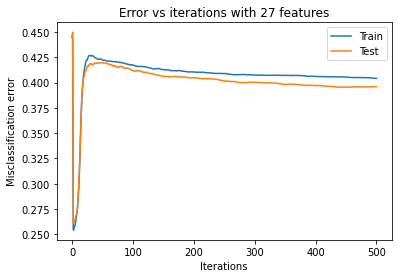

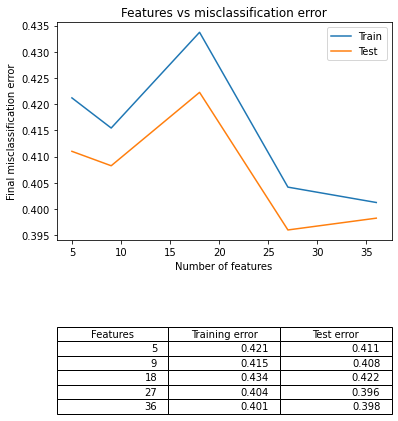

In [28]:
train_x, train_y, test_x, test_y = get_data()
k =  [5,9,18,27,36]
plot_fsa(train_x, train_y, test_x, test_y, k, L)

c) Repeat points a) and b) using the cross-entropy loss function:
$L(\bf{u}, y) = −u_y + \ln(\Sigma_{k=1}^C \exp(u_k))$
adding the misclassification errors to the table from b). (4 points).

c:\users\okosa\pycharmprojects\machinelearningassignments\venv\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


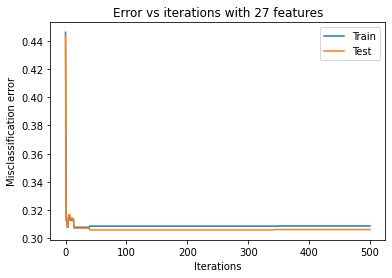

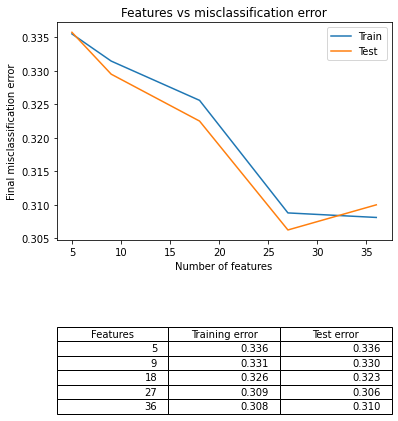

In [29]:
train_x, train_y, test_x, test_y = get_data()
k =  [5,9,18,27,36]
plot_fsa(train_x, train_y, test_x, test_y, k, L2)